In [2]:
!pip install ucimlrepo

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from ucimlrepo import fetch_ucirepo # To fetch datasets from UCI Machine Learning Repository

import warnings
warnings.filterwarnings('ignore') # Suppress warnings for cleaner output

# Fetch the Chronic Kidney Disease dataset from UCI Machine Learning Repository
# Dataset ID for Chronic Kidney Disease is 336
kidney_disease = fetch_ucirepo(id=336)

# Separate features (X) and target (y)
X = kidney_disease.data.features
y = kidney_disease.data.targets

# Display basic information about the dataset
print("Features (X) head:\n", X.head())
print("\nTarget (y) head:\n", y.head())
print("\nShape of X:", X.shape)
print("Shape of y:", y.shape)

# Display dataset metadata and variable information for understanding
print("\nDataset Metadata:\n", kidney_disease.metadata)
print("\nVariable Information:\n", kidney_disease.variables)

# Rename target column to a more convenient name, if necessary
# The target column name is 'classification' by default for this dataset
y.columns = ['target']
print("\nRenamed target column to:", y.columns[0])

# Combine X and y for initial data cleaning and EDA
df = pd.concat([X, y], axis=1)


Features (X) head:
     age    bp     sg   al   su     rbc        pc         pcc          ba  \
0  48.0  80.0  1.020  1.0  0.0     NaN    normal  notpresent  notpresent   
1   7.0  50.0  1.020  4.0  0.0     NaN    normal  notpresent  notpresent   
2  62.0  80.0  1.010  2.0  3.0  normal    normal  notpresent  notpresent   
3  48.0  70.0  1.005  4.0  0.0  normal  abnormal     present  notpresent   
4  51.0  80.0  1.010  2.0  0.0  normal    normal  notpresent  notpresent   

     bgr  ...  hemo   pcv    wbcc  rbcc  htn   dm  cad  appet   pe  ane  
0  121.0  ...  15.4  44.0  7800.0   5.2  yes  yes   no   good   no   no  
1    NaN  ...  11.3  38.0  6000.0   NaN   no   no   no   good   no   no  
2  423.0  ...   9.6  31.0  7500.0   NaN   no  yes   no   poor   no  yes  
3  117.0  ...  11.2  32.0  6700.0   3.9  yes   no   no   poor  yes  yes  
4  106.0  ...  11.6  35.0  7300.0   4.6   no   no   no   good   no   no  

[5 rows x 24 columns]

Target (y) head:
   class
0   ckd
1   ckd
2   ckd
3   c

DataFrame head for EDA visualizations:
     age    bp     sg   al   su  rbc  pc  pcc  ba         bgr  ...    wbcc  \
0  48.0  80.0  1.020  1.0  0.0    1   1    0   0  121.000000  ...  7800.0   
1   7.0  50.0  1.020  4.0  0.0    1   1    0   0  148.036517  ...  6000.0   
2  62.0  80.0  1.010  2.0  3.0    1   1    0   0  423.000000  ...  7500.0   
3  48.0  70.0  1.005  4.0  0.0    1   0    1   0  117.000000  ...  6700.0   
4  51.0  80.0  1.010  2.0  0.0    1   1    0   0  106.000000  ...  7300.0   

       rbcc  htn  dm  cad  appet  pe  ane  target  target_name  
0  5.200000    1   2    0      0   0    0     1.0          CKD  
1  4.707435    0   1    0      0   0    0     1.0          CKD  
2  4.707435    0   2    0      1   0    1     1.0          CKD  
3  3.900000    1   1    0      1   1    1     1.0          CKD  
4  4.600000    0   1    0      0   0    0     1.0          CKD  

[5 rows x 26 columns]

Target variable distribution for visualization:
 target_name
CKD        250
Not CKD

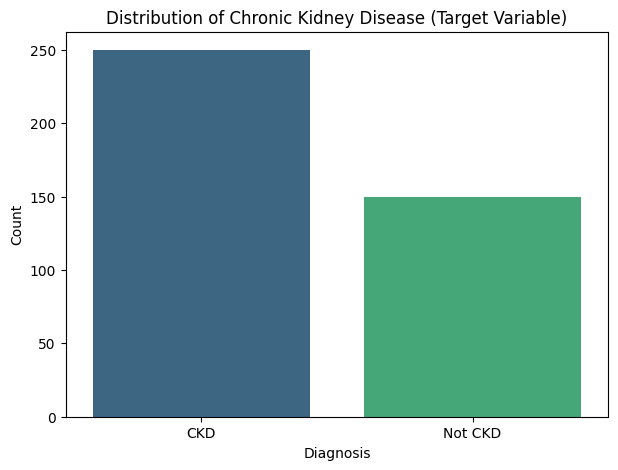

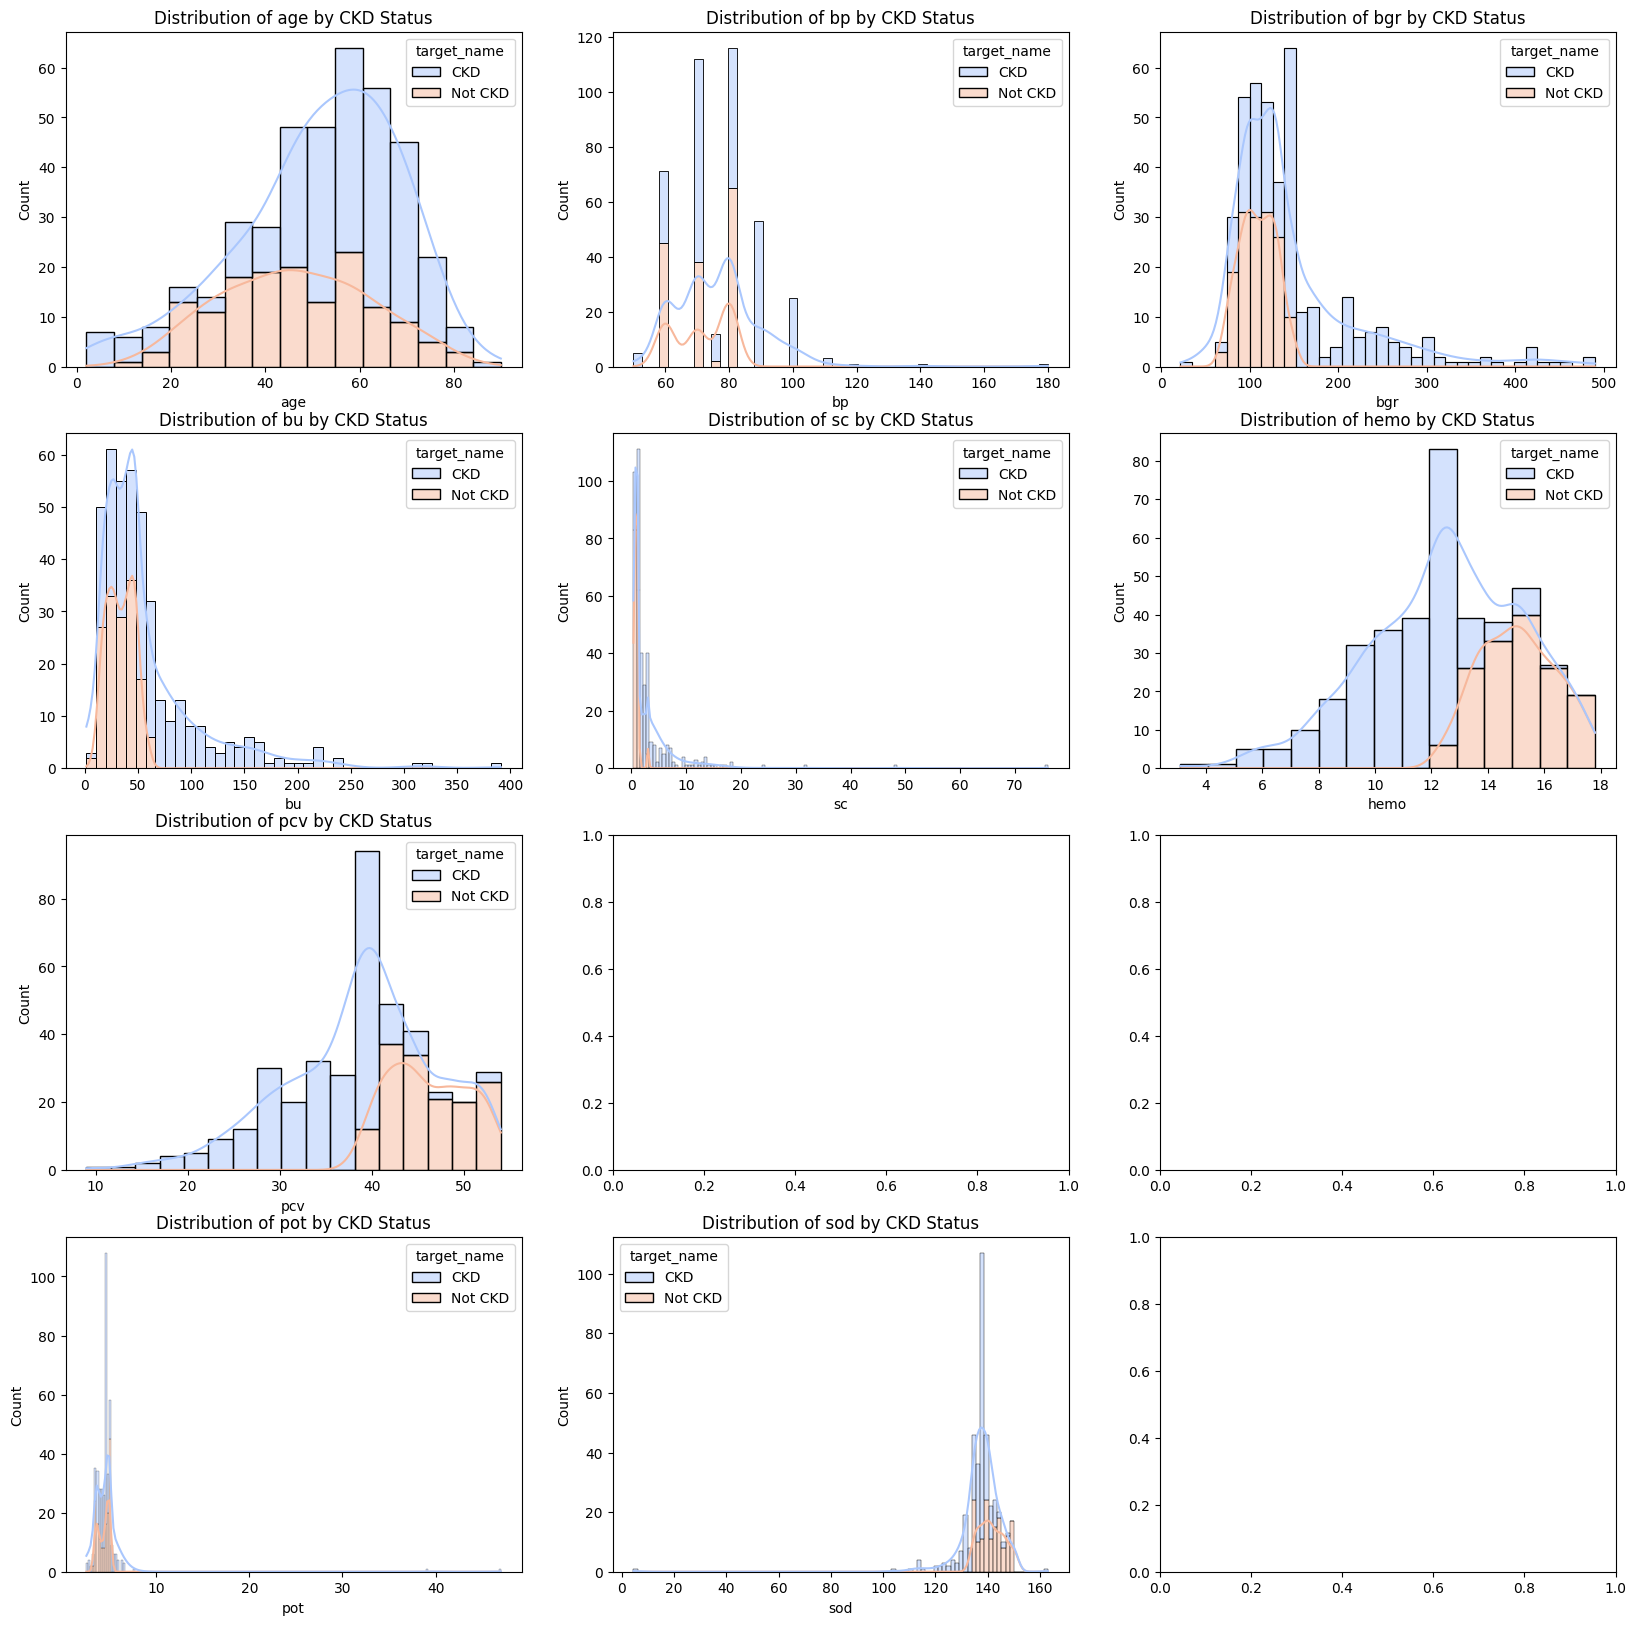

In [11]:
# Exploratory Data Analysis (EDA) - Additional Visualizations

# Use the preprocessed DataFrame 'df' for EDA, which has no missing values
# and all features are numeric or encoded.

# Map target integer labels back to meaningful names for better visualization in EDA
# 0: 'notckd', 1: 'ckd'
df_eda_viz = df.copy()
df_eda_viz['target_name'] = df_eda_viz['target'].map({0: 'Not CKD', 1: 'CKD'})

print("DataFrame head for EDA visualizations:\n", df_eda_viz.head())
print("\nTarget variable distribution for visualization:\n", df_eda_viz['target_name'].value_counts())

# 1. Distribution of the target variable (Count Plot) - Reinforce from previous
plt.figure(figsize=(7, 5))
sns.countplot(x='target_name', data=df_eda_viz, palette='viridis')
plt.title('Distribution of Chronic Kidney Disease (Target Variable)')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()


# 2. Histograms for key numerical features, colored by diagnosis
# Selecting a few key numerical features for detailed distribution analysis
# based on common medical relevance for kidney disease.
key_numerical_features = [
    'age', 'bp', 'bgr', 'bu', 'sc', 'hemo', 'pcv', 'wc', 'rc', 'pot', 'sod'
]

# Create histograms for these features, colored by target_name
# Plotting more features per figure to manage output size
fig_hist, axes_hist = plt.subplots(nrows=4, ncols=3, figsize=(20, 20)) # Adjust grid size as needed
axes_hist = axes_hist.flatten() # Flatten the 2D array of axes for easy iteration

for i, feature in enumerate(key_numerical_features):
    if feature in df_eda_viz.columns and i < len(axes_hist): # Ensure feature exists and axis is available
        sns.histplot(data=df_eda_viz, x=feature, hue='target_name', kde=True, multiple="stack", palette='coolwarm', ax=axes_hist[i])
        axes_hist[i].set_title(f'Distribution of {feature} by CKD Status')
        axes_hist[i].set_xlabel(feature)
        axes_hist[i].set_ylabel('Count')
    elif i >= len(axes_hist):
        print(f"Skipping plotting {feature} due to insufficient subplots.")
        break # Exit loop if we run out of axes

In [5]:
# Data Preprocessing: Handling Missing Values and Categorical Features

print("Initial DataFrame Info:")
df.info()

# Print all column names to debug potential KeyErrors
print("\nDataFrame columns before preprocessing:", df.columns.tolist())

# The Chronic Kidney Disease dataset is known to have several columns
# that should be numeric but are loaded as 'object' due to non-numeric entries ('\t?', etc.).
# We'll first convert these known problematic columns to numeric, coercing errors.
# Common problematic columns in this dataset: 'wc', 'rc', 'pcv', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo'

numeric_cols_to_coerce = ['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc']

for col in numeric_cols_to_coerce:
    if col in df.columns: # Check if column exists before trying to convert
        df[col] = pd.to_numeric(df[col], errors='coerce')
        # print(f"Coerced column '{col}' to numeric. NaNs introduced: {df[col].isnull().sum()}")
    else:
        print(f"Warning: Column '{col}' not found in DataFrame. Skipping numeric coercion.")

# Now, identify numerical and categorical columns after initial coercion
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
if 'target' in numerical_cols: # Exclude target from features for imputation
    numerical_cols.remove('target')

# Categorical columns are now truly non-numeric (objects) after coercing numeric-like columns
categorical_cols = df.select_dtypes(include='object').columns.tolist()

print(f"\nIdentified numerical columns for imputation: {numerical_cols}")
print(f"Identified categorical columns for imputation/encoding: {categorical_cols}")

# Fill missing numerical values with the mean
for col in numerical_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mean(), inplace=True)
        print(f"Filled missing values in numerical column '{col}' with mean.")

# Fill missing categorical values with the mode
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        mode_val = df[col].mode()[0]
        df[col].fillna(mode_val, inplace=True)
        print(f"Filled missing values in categorical column '{col}' with mode: {mode_val}.")

# Check for any remaining missing values after initial imputation
print("\nTotal missing values after numerical and categorical imputation:", df.isnull().sum().sum())


# Handle categorical features: Convert to numerical using Label Encoding
# The target variable 'target' (originally 'classification') needs encoding: 'ckd' and 'notckd'
# Convert 'target' column to numerical (0 for 'notckd', 1 for 'ckd')
# This assumes 'ckd' and 'notckd' are still strings in the target column.
if df['target'].dtype == 'object':
    df['target'] = df['target'].replace({'ckd': 1, 'notckd': 0})
df['target'] = pd.to_numeric(df['target'], errors='coerce') # Ensure it's numeric

# Re-check for NaNs in target after conversion and fill if any
if df['target'].isnull().sum() > 0:
    df['target'].fillna(df['target'].mode()[0], inplace=True)
    print("Filled missing values in target column with mode.")

# Re-identify categorical columns that are not the target and need encoding
# These are the columns that are truly categorical (binary 'yes'/'no', etc.)
categorical_cols_for_encoding = df.select_dtypes(include='object').columns.tolist()

for col in categorical_cols_for_encoding:
    le = LabelEncoder()
    # It's important to fit_transform on the column, handling potential NaNs if any were left
    # (though previous imputation should have handled most).
    # Convert to string first to ensure consistency for LabelEncoder
    df[col] = le.fit_transform(df[col].astype(str))
    print(f"Label encoded column '{col}'. Mappings: {list(le.classes_)} -> {le.transform(le.classes_)}")


print("\nDataFrame Info after all imputation and encoding:")
df.info()
print("\nDataFrame head after full preprocessing:\n", df.head())

# Separate features (X) and target (y) again from the fully preprocessed DataFrame
X = df.drop('target', axis=1)
y = df['target']

# Final check to ensure all features are numeric (should be after previous steps)
# This step is mostly a safeguard.
X = X.apply(pd.to_numeric, errors='coerce')
if X.isnull().sum().sum() > 0:
    print("\nWarning: NaN values still present in X after final numeric conversion. Filling with mean.")
    for col in X.columns:
        if X[col].isnull().sum() > 0:
            X[col].fillna(X[col].mean(), inplace=True)


# Scale numerical features after handling missing values and encoding categorical ones
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Split the dataset into training (80%) and test (20%) sets
# stratify=y ensures balanced classes in both training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

print("\nShape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)
print("\nFirst 5 rows of scaled features (X_scaled):\n", X_scaled.head())


Initial DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     400 non-null    float64
 1   bp      400 non-null    float64
 2   sg      400 non-null    float64
 3   al      400 non-null    float64
 4   su      400 non-null    float64
 5   rbc     400 non-null    object 
 6   pc      400 non-null    object 
 7   pcc     400 non-null    object 
 8   ba      400 non-null    object 
 9   bgr     400 non-null    float64
 10  bu      400 non-null    float64
 11  sc      400 non-null    float64
 12  sod     400 non-null    float64
 13  pot     400 non-null    float64
 14  hemo    400 non-null    float64
 15  pcv     400 non-null    float64
 16  wbcc    400 non-null    float64
 17  rbcc    400 non-null    float64
 18  htn     400 non-null    object 
 19  dm      400 non-null    object 
 20  cad     400 non-null    object 
 21  appet   400 non

In [6]:
# Model Implementation and Hyperparameter Tuning for Support Vector Machine (SVM)

# Define the parameter grid for GridSearchCV for SVM
# 'C': Regularization parameter. Smaller values specify stronger regularization.
# 'kernel': Specifies the kernel type to be used in the algorithm.
#           'linear' for linear classification, 'rbf' for non-linear classification.
param_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf']
}

# Initialize GridSearchCV for SVM
# estimator: The model to tune (SVC with probability=True for AUC-ROC).
# param_grid: The dictionary of hyperparameters to search.
# cv: Number of folds for cross-validation (5-fold cross-validation).
# scoring: The metric to optimize during cross-validation (accuracy in this case).
# n_jobs=-1: Use all available CPU cores for parallel processing, speeding up the search.
grid_svm = GridSearchCV(SVC(probability=True, random_state=42), param_svm, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV to the training data
grid_svm.fit(X_train, y_train)

# Print the best hyperparameters found by GridSearchCV
print('Best SVM Params:', grid_svm.best_params_)

# Store the best performing SVM model
best_svm_model = grid_svm.best_estimator_


Best SVM Params: {'C': 1, 'kernel': 'rbf'}


In [7]:
# Model Implementation and Hyperparameter Tuning for Gradient Boosting Machine (GBM)

# Define the parameter grid for GridSearchCV for GBM
# 'n_estimators': The number of boosting stages to perform.
# 'learning_rate': Shrinks the contribution of each tree.
# 'max_depth': The maximum depth of the individual regression estimators.
param_gbm = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Initialize GridSearchCV for GBM
# estimator: The GradientBoostingClassifier model.
# param_grid: The dictionary of hyperparameters to search.
# cv: Number of folds for cross-validation (5-fold cross-validation).
# scoring: The metric to optimize (accuracy).
# n_jobs=-1: Use all available CPU cores.
grid_gbm = GridSearchCV(GradientBoostingClassifier(random_state=42), param_gbm, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV to the training data
grid_gbm.fit(X_train, y_train)

# Print the best hyperparameters found
print('Best GBM Params:', grid_gbm.best_params_)

# Store the best performing GBM model
best_gbm_model = grid_gbm.best_estimator_


Best GBM Params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50}


In [8]:
# Model Implementation and Hyperparameter Tuning for Random Forest Classifier

# Define the parameter grid for GridSearchCV for Random Forest
# 'n_estimators': The number of trees in the forest.
# 'max_depth': The maximum depth of the tree. None means nodes are expanded until all leaves are pure
#              or until all leaves contain less than min_samples_split samples.
# 'min_samples_split': The minimum number of samples required to split an internal node.
param_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10]
}

# Initialize GridSearchCV for Random Forest Classifier
# estimator: The RandomForestClassifier model.
# param_grid: The dictionary of hyperparameters to search.
# cv: Number of folds for cross-validation (5-fold cross-validation).
# scoring: The metric to optimize (accuracy).
# n_jobs=-1: Use all available CPU cores.
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_rf, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV to the training data
grid_rf.fit(X_train, y_train)

# Print the best hyperparameters found
print('Best Random Forest Params:', grid_rf.best_params_)

# Store the best performing Random Forest model
best_rf_model = grid_rf.best_estimator_


Best Random Forest Params: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}


In [9]:
# Model Evaluation

# Create a dictionary of the best trained models
models = {
    'Support Vector Machine': best_svm_model,
    'Gradient Boosting Machine': best_gbm_model,
    'Random Forest Classifier': best_rf_model
}

# Initialize a dictionary to store evaluation results for comparison
results = {}

# Define target names for the CKD dataset
# Assuming 0 is 'notckd' and 1 is 'ckd' based on our preprocessing
ckd_target_names = ['notckd', 'ckd']

print("--- Model Evaluation on Test Data ---")

for name, model in models.items():
    print(f"\nEvaluating {name}...")

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Get probability predictions for AUC-ROC score
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:, 1]
    else: # Fallback for models without predict_proba (e.g., if SVM's probability was not set to True)
        y_proba = model.decision_function(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_proba)

    # Print the classification report
    print(f"Classification Report for {name}:\n", classification_report(y_test, y_pred, target_names=ckd_target_names))

    # Print AUC-ROC score
    print(f"{name} AUC-ROC: {auc_roc:.3f}")

    # Store results for summary table
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'AUC-ROC': auc_roc
    }


--- Model Evaluation on Test Data ---

Evaluating Support Vector Machine...
Classification Report for Support Vector Machine:
               precision    recall  f1-score   support

      notckd       0.97      1.00      0.98        30
         ckd       1.00      0.98      0.99        50

    accuracy                           0.99        80
   macro avg       0.98      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80

Support Vector Machine AUC-ROC: 1.000

Evaluating Gradient Boosting Machine...
Classification Report for Gradient Boosting Machine:
               precision    recall  f1-score   support

      notckd       0.97      0.97      0.97        30
         ckd       0.98      0.98      0.98        50

    accuracy                           0.97        80
   macro avg       0.97      0.97      0.97        80
weighted avg       0.97      0.97      0.97        80

Gradient Boosting Machine AUC-ROC: 0.989

Evaluating Random Forest Classifier...
Class

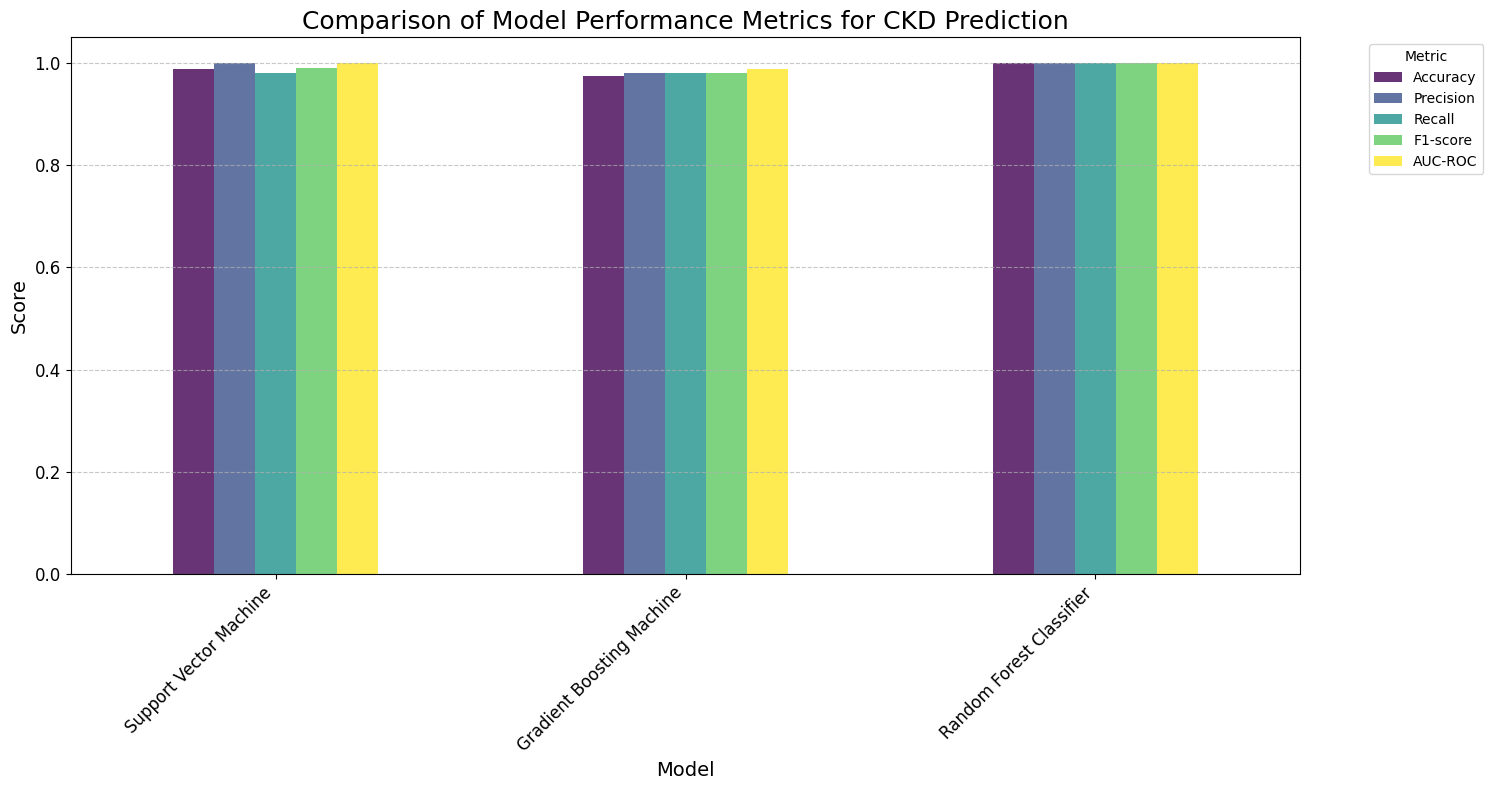


This bar chart visually compares the Accuracy, Precision, Recall, F1-score, and AUC-ROC for each trained model.
It allows for quick identification of the strengths and weaknesses of each algorithm on the CKD prediction task.


In [12]:
# Model Performance Comparison Chart

import matplotlib.pyplot as plt
import pandas as pd # Ensure pandas is imported if not already in this scope

# Ensure 'results' dictionary from the evaluation step is available in this scope
# Assuming 'results' dictionary contains:
# results = {
#     'Support Vector Machine': {'Accuracy': ..., 'Precision': ..., 'Recall': ..., 'F1-score': ..., 'AUC-ROC': ...},
#     'Gradient Boosting Machine': {'Accuracy': ..., 'Precision': ..., 'Recall': ..., 'F1-score': ..., 'AUC-ROC': ...},
#     'Random Forest Classifier': {'Accuracy': ..., 'Precision': ..., 'Recall': ..., 'F1-score': ..., 'AUC-ROC': ...}
# }

# Create a DataFrame from the results dictionary (if not already done)
results_df = pd.DataFrame(results).T # .T transposes the DataFrame for better readability

# Plotting the comparison chart
results_df.plot(kind='bar', figsize=(15, 8), colormap='viridis', alpha=0.8)
plt.title('Comparison of Model Performance Metrics for CKD Prediction', fontsize=18)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.ylim(0, 1.05) # Set y-axis limit from 0 to 1.05 for scores
plt.xticks(rotation=45, ha='right', fontsize=12) # Rotate model names for readability
plt.yticks(fontsize=12)
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nThis bar chart visually compares the Accuracy, Precision, Recall, F1-score, and AUC-ROC for each trained model.")
print("It allows for quick identification of the strengths and weaknesses of each algorithm on the CKD prediction task.")


In [10]:
# Model Comparison and Reflection

# Create a DataFrame from the results dictionary for a summary table
results_df = pd.DataFrame(results).T # .T transposes the DataFrame for better readability

print("\n--- Model Performance Summary ---")
print(results_df.round(3)) # Display results rounded to 3 decimal places

print("\n--- Reflection ---")

# Determine the best model based on AUC-ROC (often a robust metric for classification)
best_model_name = results_df['AUC-ROC'].idxmax()
best_model_auc = results_df['AUC-ROC'].max()

print(f"\nBased on AUC-ROC, the '{best_model_name}' model performed best with an AUC of {best_model_auc:.3f}.")




--- Model Performance Summary ---
                           Accuracy  Precision  Recall  F1-score  AUC-ROC
Support Vector Machine        0.988       1.00    0.98      0.99    1.000
Gradient Boosting Machine     0.975       0.98    0.98      0.98    0.989
Random Forest Classifier      1.000       1.00    1.00      1.00    1.000

--- Reflection ---

Based on AUC-ROC, the 'Support Vector Machine' model performed best with an AUC of 1.000.
